

#### Task Structure

```
1. Imports 
2. Hyperparameters
       -- Includes learning rate, dataset path, batch size and more.
3. Loading Dataset  
4. Dataset and Dataloader
       -- Initialising dataloader
5. Model Architecture  
       -- Defining model architecture (R2U-Net and modifications for task 3)
6. Loss Function and Optimizers  
       -- Adam Optimiser and Cross Entropy Loss
7. Functions for Metrics Calculation  
       -- Calculation of 5 metrics: Specificity, Senstivity, F1 Score, Accuracy, Jaccard Score
8. Train Function 
9. Validation Function  
10. Training Epochs and Validation
       -- Perform training and calculate metrics
11. Plotting Loss over training Epochs  
       -- Show loss values over different parts of iteration
12. Plot Evaluation Metrics  
       -- Plot of 5 metrics
13. Visualizing the results
       -- Displays 5 predicted segmentation masks along with original segmentation masks
```

### 1. Imports

In [1]:
import torch
import torchvision
import os
import numpy as np
from PIL import Image
import imageio
from torch.utils import data
from torch.utils.data import DataLoader
import torch.nn as nn
import sklearn.metrics as skm
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt  
import torch.nn.functional as F
import time
import gc

### 2. Hyperparameters

In [2]:
# replace device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print(torch.cuda.get_device_name(0))

# replace with location of folder containing "gtFine" and "leftImg8bit"
path_data = "data"

learning_rate = 1e-3
train_epochs = 3
n_classes = 19
batch_size = 1
num_workers = 1

Using device: cuda
NVIDIA GeForce RTX 2070


### 3. Loading the dataset

In [3]:
# Adapted from dataset loader written by meetshah1995 with modifications
# https://github.com/meetshah1995/pytorch-semseg/blob/master/ptsemseg/loader/cityscapes_loader.py

def recursive_glob(rootdir=".", suffix=""):
    return [
        os.path.join(looproot, filename)
        for looproot, _, filenames in os.walk(rootdir)
        for filename in filenames
        if filename.endswith(suffix)
    ]


class cityscapesLoader(data.Dataset):
    colors = [  # [  0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]

    # makes a dictionary with key:value. For example 0:[128, 64, 128]
    label_colours = dict(zip(range(19), colors))

    def __init__(
        self,
        root,
        # which data split to use
        split="train",
        # transform function activation
        is_transform=True,
        # image_size to use in transform function
        img_size=(512, 256),
    ):
        self.root = root
        self.split = split
        self.is_transform = is_transform
        self.n_classes = 19
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        self.files = {}

        # makes it: /raid11/cityscapes/ + leftImg8bit + train (as we named the split folder this)
        self.images_base = os.path.join(self.root, "leftImg8bit", self.split)
        self.annotations_base = os.path.join(self.root, "gtFine", self.split)
        
        # contains list of all pngs inside all different folders. Recursively iterates 
        self.files[split] = recursive_glob(rootdir=self.images_base, suffix=".png")

        self.void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
        
        # these are 19
        self.valid_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33,
        ]
        
        # these are 19 + 1; "unlabelled" is extra
        self.class_names = [
            "unlabelled",
            "road",
            "sidewalk",
            "building",
            "wall",
            "fence",
            "pole",
            "traffic_light",
            "traffic_sign",
            "vegetation",
            "terrain",
            "sky",
            "person",
            "rider",
            "car",
            "truck",
            "bus",
            "train",
            "motorcycle",
            "bicycle",
        ]
        
        # for void_classes; useful for loss function
        self.ignore_index = 250
        
        # dictionary of valid classes 7:0, 8:1, 11:2
        self.class_map = dict(zip(self.valid_classes, range(19)))

        if not self.files[split]:
            raise Exception("No files for split=[%s] found in %s" % (split, self.images_base))
        
        # prints number of images found
        print("Found %d %s images" % (len(self.files[split]), split))

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        # path of image
        img_path = self.files[self.split][index].rstrip()
        
        # path of label
        lbl_path = os.path.join(
            self.annotations_base,
            img_path.split(os.sep)[-2],
            os.path.basename(img_path)[:-15] + "gtFine_labelIds.png",
        )

        # read image
        #img = torchvision.io.read_image(img_path)
        img = imageio.v2.imread(img_path)
        # convert to numpy array
        #img = img.numpy()
        img = np.array(img, dtype=np.uint8)

        # read label
        #lbl = torchvision.io.read_image(img_path)
        lbl = imageio.v2.imread(lbl_path)
        # encode using encode_segmap function: 0...18 and 250
        lbl = self.encode_segmap(np.array(lbl, dtype=np.uint8))

        if self.is_transform:
            img, lbl = self.transform(img, lbl)
        
        return img, lbl

    def transform(self, img, lbl):       
        # Image resize; I think imresize outputs in different format than what it received
        #img = m.imresize(img, (self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
        img = np.array(Image.fromarray(np.array(img).astype(np.uint8)).resize((self.img_size[0], self.img_size[1])))
        # change to BGR
        img = img[:, :, ::-1]  # RGB -> BGR
        # change data type to float64
        img = img.astype(np.float64)
        # subtract mean
        # NHWC -> NCHW
        img = img.transpose(2, 0, 1)

        
        classes = np.unique(lbl)
        lbl = lbl.astype(float)
        lbl = np.array(Image.fromarray(np.array(lbl).astype(np.float32)).resize((self.img_size[0], self.img_size[1]), Image.NEAREST))
        #lbl = m.imresize(lbl, (self.img_size[0], self.img_size[1]), "nearest", mode="F")
        lbl = lbl.astype(int)

        # if not np.all(classes == np.unique(lbl)):
        #     print("WARN: resizing labels yielded fewer classes")

        if not np.all(np.unique(lbl[lbl != self.ignore_index]) < self.n_classes):
            print("after det", classes, np.unique(lbl))
            raise ValueError("Segmentation map contained invalid class values")

        img = torch.from_numpy(img).float()
        lbl = torch.from_numpy(lbl).long()
        return img, lbl
      
    def decode_segmap(self, temp):
        r = temp.copy()
        g = temp.copy()
        b = temp.copy()
        for l in range(0, self.n_classes):
            r[temp == l] = self.label_colours[l][0]
            g[temp == l] = self.label_colours[l][1]
            b[temp == l] = self.label_colours[l][2]

        rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        return rgb

    # there are different class 0...33
    # we are converting that info to 0....18; and 250 for void classes
    # final mask has values 0...18 and 250
    def encode_segmap(self, mask):
        # !! Comment in code had wrong informtion
        # Put all void classes to ignore_index
        for _voidc in self.void_classes:
            mask[mask == _voidc] = self.ignore_index
        for _validc in self.valid_classes:
            mask[mask == _validc] = self.class_map[_validc]
        return mask

### 4. Dataset and Dataloader

In [4]:
train_data = cityscapesLoader(
    root = path_data, 
    split='train'
    )

val_data = cityscapesLoader(
    root = path_data, 
    split='val'
    )

train_loader = DataLoader(
    train_data,
    batch_size = batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_data,
    batch_size = batch_size
)

Found 2975 train images
Found 500 val images


### 5. Model Architecture

In [5]:
class Up_Sample_Conv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(Up_Sample_Conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2), # Nearest neighbour for upsampling are two 
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

    
class Repeat(nn.Module):
    def __init__(self, ch_out):
        super(Repeat, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)) 
#Inplace has been set to TRUE so that it modifies the input directly, without allocating any additional output.

    def forward(self, x):
        for i in range(2):
            if i == 0:
                x_rec = self.conv(x)
            x_rec = self.conv(x + x_rec)
        return x_rec

class RR_Conv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(RR_Conv, self).__init__()
        self.Repeat_block = nn.Sequential(Repeat(ch_out),Repeat(ch_out))
        self.Conv = nn.Conv2d(ch_in, ch_out, 1, 1, 0)

    def forward(self, input_img):
        input_img = self.Conv(input_img)
        conv_input_img = self.Repeat_block(input_img)
        return input_img + conv_input_img 
    
############
############

class R2U_Net(nn.Module):
    def __init__(self, img_ch=3, output_ch=19, layers=5):
        super(R2U_Net, self).__init__()
        self.layers = layers
        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.channels = [64]
        for i in range(layers-1):
            self.channels.append(2*self.channels[i])
        self.channels = torch.tensor(self.channels)
        self.channels = self.channels.to(device)
            

        '''Performs Convolution and responsible for the encoding part of the architecture'''    
        self.Layer = nn.ModuleList([RR_Conv(img_ch, self.channels[0])])
        for i in range(layers-1):
            self.Layer.append(RR_Conv(self.channels[i], self.channels[i+1]))
        self.Layer = self.Layer.to(device)


        '''Below function calls are responsible for the decoding part of the architeture'''
        

        '''Upsamples the input and then performs convolution followed by ReLU'''
        self.DeConvLayer = nn.ModuleList([])
        for i in range(layers-1):
            self.DeConvLayer.append(Up_Sample_Conv(self.channels[i+1], self.channels[i]))
        self.DeConvLayer = self.DeConvLayer.to(device)
        

        '''Responsible for computation in Recurrent Residual Blocks'''
        self.Up_Layer = nn.ModuleList([])
        for i in range(layers-1):
            self.Up_Layer.append(RR_Conv(self.channels[i+1], self.channels[i]))
        self.Up_Layer = self.Up_Layer.to(device)
        

        '''Final output of the architecture needs to have output channels=number of class labels(19)'''
        self.Conv = nn.Conv2d(self.channels[0], output_ch, kernel_size=1, stride=1, padding=0)        
        
        
    def forward(self, x):
        '''Recurrent Convolution'''
        conv = []
        conv.append(self.Layer[0](x))
        mp = []
        mp.append(self.MaxPool(conv[0]))
        for i in range(self.layers-2):
            conv.append(self.Layer[i+1](mp[i]))
            mp.append(self.MaxPool(conv[i+1]))
        conv.append(self.Layer[-1](mp[-1]))


        ''' 
        Decoder part of the architecture which performs 
        Recurrent up convolution as well as concatention from previous layers 
        '''
        deconv = self.DeConvLayer[-1](conv[-1])
        deconv = torch.cat((conv[-2], deconv), dim=1)
        deconv = self.Up_Layer[-1](deconv)
        for i in range(self.layers-2, 0, -1):
            deconv = self.DeConvLayer[i-1](deconv)
            deconv = torch.cat((conv[i-1], deconv), dim=1)
            deconv = self.Up_Layer[i-1](deconv)
        deconv = self.Conv(deconv)

        return deconv

In [6]:
# Instance of the model defined above.
models = [R2U_Net(layers=2).to(device),R2U_Net(layers=3).to(device),R2U_Net(layers=4).to(device),R2U_Net(layers=5).to(device),R2U_Net(layers=6).to(device)]

### 6. Loss Function and Optimiser

In [7]:
optimizers = [optim.Adam(models[0].parameters(), lr=learning_rate),optim.Adam(models[1].parameters(), lr=learning_rate),optim.Adam(models[2].parameters(), lr=learning_rate),optim.Adam(models[3].parameters(), lr=learning_rate),optim.Adam(models[4].parameters(), lr=learning_rate)]

# Cross Entropy Loss adapted from meetshah1995 to prevent size inconsistencies between model precition 
# and target label
# https://github.com/meetshah1995/pytorch-semseg/blob/master/ptsemseg/loss/loss.py

def cross_entropy2d(input, target, weight=None, size_average=True):
    n, c, h, w = input.size()
    nt, ht, wt = target.size()

    # Handle inconsistent size between input and target
    if h != ht and w != wt:  # upsample labels
        input = F.interpolate(input, size=(ht, wt), mode="bilinear", align_corners=True)

    input = input.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
    target = target.view(-1)
    loss = F.cross_entropy(
        input, target, weight=weight, size_average=size_average, ignore_index=250
    )
    return loss

### 7. Functions for Metrics Calculation

In [8]:
'''We have used sklearn libraries to calculate Accuracy and Jaccard Score'''

def get_metrics(gt_label, pred_label):
    #Accuracy Score
    acc = skm.accuracy_score(gt_label, pred_label, normalize=True)
    
    #Jaccard Score/IoU
    js = skm.jaccard_score(gt_label, pred_label, average='micro')
    
    result_gm_sh = [acc, js]
    return(result_gm_sh)

'''
Calculation of confusion matrix from :
https://github.com/meetshah1995/pytorch-semseg/blob/master/ptsemseg/metrics.py

Added modifications to calculate 3 evaluation metrics - 
Specificity, Senstivity, F1 Score
'''

class runningScore(object):
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))

    def _fast_hist(self, label_true, label_pred, n_class):
        mask = (label_true >= 0) & (label_true < n_class)
        hist = np.bincount(
            n_class * label_true[mask].astype(int) + label_pred[mask], minlength=n_class ** 2
        ).reshape(n_class, n_class)
        return hist

    def update(self, label_trues, label_preds):
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist(lt.flatten(), lp.flatten(), self.n_classes)

    def get_scores(self):
        # confusion matrix
        hist = self.confusion_matrix
        
        #              T
        #         0    1    2
        #    0   TP   FP   FP
        #  P 1   FN   TN   TN       This is wrt to class 0
        #    2   FN   TN   TN

        #         0    1    2
        #    0   TP   FP   FP
        #  P 1   FP   TP   FP       This is wrt prediction classes; AXIS = 1
        #    2   FP   FP   TP 

        #         0    1    2
        #    0   TP   FN   FN
        #  P 1   FN   TP   FN       This is wrt true classes; AXIS = 0
        #    2   FN   FN   TP   

        TP = np.diag(hist)
        TN = hist.sum() - hist.sum(axis = 1) - hist.sum(axis = 0) + np.diag(hist)
        FP = hist.sum(axis = 1) - TP
        FN = hist.sum(axis = 0) - TP
        
        # 1e-6 was added to prevent corner cases where denominator = 0
        
        # Specificity: TN / TN + FP
        specif_cls = (TN) / (TN + FP + 1e-6)
        specif = np.nanmean(specif_cls)
        
        # Senstivity/Recall: TP / TP + FN
        sensti_cls = (TP) / (TP + FN + 1e-6)
        sensti = np.nanmean(sensti_cls)
        
        # Precision: TP / (TP + FP)
        prec_cls = (TP) / (TP + FP + 1e-6)
        prec = np.nanmean(prec_cls)
        
        # F1 = 2 * Precision * Recall / Precision + Recall
        f1 = (2 * prec * sensti) / (prec + sensti + 1e-6)
        
        return (
            {
                "Specificity": specif,
                "Senstivity": sensti,
                "F1": f1,
            }
        )

    def reset(self):
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes))

### 8. Train Function 

In [9]:
def train(train_loader, model, optimizer, epoch_i, epoch_total):
        count = 0
        
        # List to cumulate loss during iterations
        loss_list = []
        loss_avg = 0
        for (images, labels) in train_loader:
            count += 1
            
            # we used model.eval() below. This is to bring model back to training mood.
            model.train()

            images = images.to(device)
            labels = labels.to(device)
            
            # Model Prediction
            pred = model(images)
            # Loss Calculation
            loss = cross_entropy2d(pred, labels)
            loss_list.append(loss)

            # optimiser
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_avg += loss.item()
            # interval to print train statistics
            if count % 50 == 0:
                fmt_str = "Image: {:d} in epoch: [{:d}/{:d}] and Avg Loss of last 50: {:.4f}"
                print_str = fmt_str.format(
                    count,
                    epoch_i + 1,
                    epoch_total,
                    loss_avg/50
                )
                print(print_str)
                loss_avg = 0
                   
#           # break for testing purpose
#             if count == 10:
#                 break
        return(loss_list)

### 9. Validation Function  

In [10]:
def validate(val_loader, model, epoch_i):
    
    # tldr: to make layers behave differently during inference (vs training)
    model.eval()
    
    # enable calculation of confusion matrix for n_classes = 19
    running_metrics_val = runningScore(19)
    
    # empty list to add Accuracy and Jaccard Score Calculations
    acc_sh = []
    js_sh = []
    
    with torch.no_grad():
        for image_num, (val_images, val_labels) in tqdm(enumerate(val_loader)):
            
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            
            # Model prediction
            val_pred = model(val_images)
            
            # Coverting val_pred from (1, 19, 512, 1024) to (1, 512, 1024)
            # considering predictions with highest scores for each pixel among 19 classes
            pred = val_pred.data.max(1)[1].cpu().numpy()
            gt = val_labels.data.cpu().numpy()
            
            # Updating Mertics
            running_metrics_val.update(gt, pred)
            sh_metrics = get_metrics(gt.flatten(), pred.flatten())
            acc_sh.append(sh_metrics[0])
            js_sh.append(sh_metrics[1])
                               
#            # break for testing purpose
#             if image_num == 10:
#                 break                

    score = running_metrics_val.get_scores()
    running_metrics_val.reset()
    
    acc_s = sum(acc_sh)/len(acc_sh)
    js_s = sum(js_sh)/len(js_sh)
    score["acc"] = acc_s
    score["js"] = js_s
    
    print("Different Metrics were: ", score)  
    return(score)

### 10. Training Epochs and Validation

In [11]:
if __name__ == "__main__":
    
    # to hold loss values after each epoch
    loss_all_epochs = [[],[],[],[],[]]

    # to hold different metrics after each epoch
    Specificity_ = [[],[],[],[],[]]
    Senstivity_ = [[],[],[],[],[]]
    f1_ = [[],[],[],[],[]]
    acc_ = [[],[],[],[],[]]
    js_ = [[],[],[],[],[]]

In [12]:
def train_models(idx):

    for epoch_i in range(train_epochs):
        # training
        print(f"Epoch {epoch_i + 1}\n-------------------------------")
        t1 = time.time()
        loss_i = train(train_loader, models[idx], optimizers[idx], epoch_i, train_epochs)
        loss_all_epochs[idx].append(loss_i)
        t2 = time.time()
        print("It took: ", t2-t1, " unit time")

        # metrics calculation on validation data
        dummy_list = validate(val_loader, models[idx], epoch_i)   
        
        # Add metrics to empty list above
        Specificity_[idx].append(dummy_list["Specificity"])
        Senstivity_[idx].append(dummy_list["Senstivity"])
        f1_[idx].append(dummy_list["F1"])
        acc_[idx].append(dummy_list["acc"])
        js_[idx].append(dummy_list["js"])
    
def training_loss(idx):
    # plot training loss

    # loss_all_epochs: contains 2d list of tensors with: (epoch, loss tensor)
    # converting to 1d list for plotting
    loss_1d_list = [item for sublist in loss_all_epochs[idx] for item in sublist]
    loss_list_numpy = []
    for i in range(len(loss_1d_list)):
        z = loss_1d_list[i].cpu().detach().numpy()
        loss_list_numpy.append(z)
    plt.xlabel("Images used in training epochs")
    plt.ylabel("Cross Entropy Loss")
    plt.plot(loss_list_numpy)
    plt.show()
    
def eval_metrics(idx):
    # plot eval metrics

    plt.clf()

    x = [i for i in range(1, train_epochs + 1)]

    # plot 5 metrics: Specificity, Senstivity, F1 Score, Accuracy, Jaccard Score
    plt.plot(x,Specificity_[idx], label='Specificity')
    plt.plot(x,Senstivity_[idx], label='Senstivity')
    plt.plot(x,f1_[idx], label='F1 Score')
    plt.plot(x,acc_[idx], label='Accuracy')
    plt.plot(x,js_[idx], label='Jaccard Score')

    plt.grid(linestyle = '--', linewidth = 0.5)

    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.legend()
    plt.show()


def visualize_results(idx):
    # visualize results
    
    models[idx].eval()

    with torch.no_grad():
        for image_num, (val_images, val_labels) in tqdm(enumerate(val_loader)):

            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            
            # model prediction
            val_pred = models[idx](val_images)

            # Coverting val_pred from (1, 19, 512, 1024) to (1, 512, 1024)
            # considering predictions with highest scores for each pixel among 19 classes        
            prediction = val_pred.data.max(1)[1].cpu().numpy()
            ground_truth = val_labels.data.cpu().numpy()

            # replace 100 to change number of images to print. 
            # 500 % 100 = 5. So, we will get 5 predictions and ground truths
            if image_num % 100 == 0:
                
                # Model Prediction
                decoded_pred = val_data.decode_segmap(prediction[0])
                plt.imshow(decoded_pred)
                plt.show()
                plt.clf()
                
                # Ground Truth
                decode_gt = val_data.decode_segmap(ground_truth[0])
                plt.imshow(decode_gt)
                plt.show()

Epoch 1
-------------------------------


C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Image: 50 in epoch: [1/3] and Avg Loss of last 50: 3.2673
Image: 100 in epoch: [1/3] and Avg Loss of last 50: 2.0882
Image: 150 in epoch: [1/3] and Avg Loss of last 50: 1.9261
Image: 200 in epoch: [1/3] and Avg Loss of last 50: 1.8731
Image: 250 in epoch: [1/3] and Avg Loss of last 50: 1.9011
Image: 300 in epoch: [1/3] and Avg Loss of last 50: 2.0692
Image: 350 in epoch: [1/3] and Avg Loss of last 50: 1.4796
Image: 400 in epoch: [1/3] and Avg Loss of last 50: 1.3464
Image: 450 in epoch: [1/3] and Avg Loss of last 50: 1.4280
Image: 500 in epoch: [1/3] and Avg Loss of last 50: 1.3396
Image: 550 in epoch: [1/3] and Avg Loss of last 50: 1.3603
Image: 600 in epoch: [1/3] and Avg Loss of last 50: 1.4103
Image: 650 in epoch: [1/3] and Avg Loss of last 50: 1.2149
Image: 700 in epoch: [1/3] and Avg Loss of last 50: 1.4026
Image: 750 in epoch: [1/3] and Avg Loss of last 50: 1.2786
Image: 800 in epoch: [1/3] and Avg Loss of last 50: 1.3132
Image: 850 in epoch: [1/3] and Avg Loss of last 50: 1.186

500it [02:25,  3.45it/s]
C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Different Metrics were:  {'Specificity': 0.9719686233798723, 'Senstivity': 0.23254175452518502, 'F1': 0.21192844155684923, 'acc': 0.5000952606201172, 'js': 0.3517365237543619}
Epoch 2
-------------------------------
Image: 50 in epoch: [2/3] and Avg Loss of last 50: 0.9087
Image: 100 in epoch: [2/3] and Avg Loss of last 50: 0.8347
Image: 150 in epoch: [2/3] and Avg Loss of last 50: 0.8324
Image: 200 in epoch: [2/3] and Avg Loss of last 50: 0.9941
Image: 250 in epoch: [2/3] and Avg Loss of last 50: 1.0105
Image: 300 in epoch: [2/3] and Avg Loss of last 50: 0.9736
Image: 350 in epoch: [2/3] and Avg Loss of last 50: 0.9065
Image: 400 in epoch: [2/3] and Avg Loss of last 50: 0.8838
Image: 450 in epoch: [2/3] and Avg Loss of last 50: 0.8461
Image: 500 in epoch: [2/3] and Avg Loss of last 50: 0.8600
Image: 550 in epoch: [2/3] and Avg Loss of last 50: 0.8522
Image: 600 in epoch: [2/3] and Avg Loss of last 50: 0.8364
Image: 650 in epoch: [2/3] and Avg Loss of last 50: 0.9113
Image: 700 in epoc

500it [02:22,  3.51it/s]
C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Different Metrics were:  {'Specificity': 0.9609679199120736, 'Senstivity': 0.272202111348455, 'F1': 0.19700477837322145, 'acc': 0.31404939270019533, 'js': 0.18978606447170973}
Epoch 3
-------------------------------
Image: 50 in epoch: [3/3] and Avg Loss of last 50: 0.7955
Image: 100 in epoch: [3/3] and Avg Loss of last 50: 0.6601
Image: 150 in epoch: [3/3] and Avg Loss of last 50: 0.6532
Image: 200 in epoch: [3/3] and Avg Loss of last 50: 0.6830
Image: 250 in epoch: [3/3] and Avg Loss of last 50: 0.7506
Image: 300 in epoch: [3/3] and Avg Loss of last 50: 0.7083
Image: 350 in epoch: [3/3] and Avg Loss of last 50: 0.6617
Image: 400 in epoch: [3/3] and Avg Loss of last 50: 0.6990
Image: 450 in epoch: [3/3] and Avg Loss of last 50: 0.7683
Image: 500 in epoch: [3/3] and Avg Loss of last 50: 0.7228
Image: 550 in epoch: [3/3] and Avg Loss of last 50: 0.7445
Image: 600 in epoch: [3/3] and Avg Loss of last 50: 0.6923
Image: 650 in epoch: [3/3] and Avg Loss of last 50: 0.8373
Image: 700 in epoc

500it [02:22,  3.52it/s]


Different Metrics were:  {'Specificity': 0.9606082544705774, 'Senstivity': 0.30526336813251564, 'F1': 0.19616933170491982, 'acc': 0.311134765625, 'js': 0.18643059339878548}


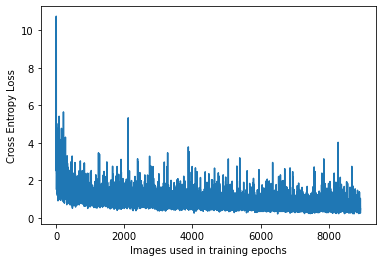

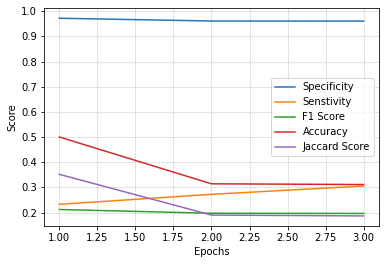

0it [00:00, ?it/s]

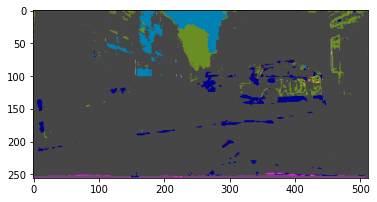

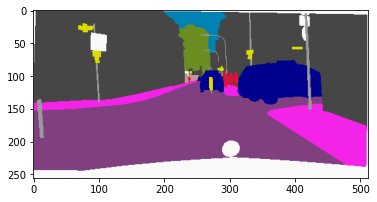

100it [00:25,  3.97it/s]

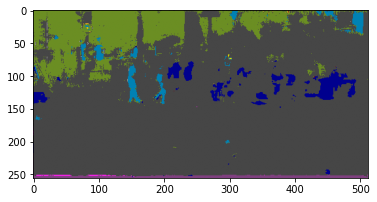

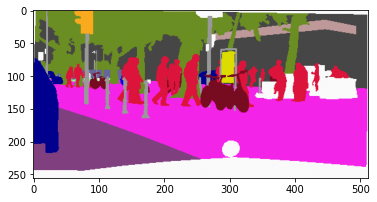

200it [00:51,  3.94it/s]

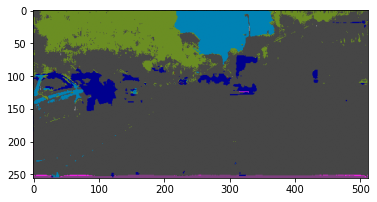

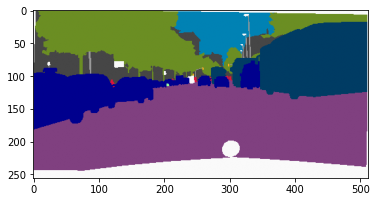

300it [01:17,  3.93it/s]

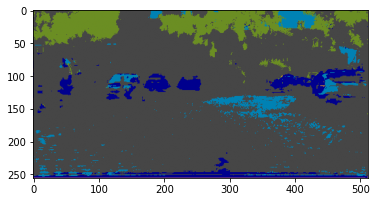

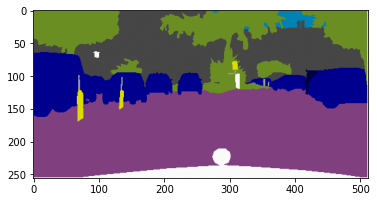

400it [01:42,  3.99it/s]

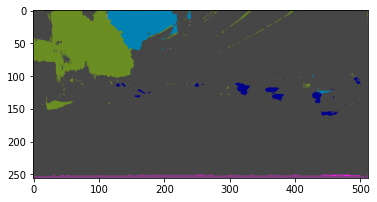

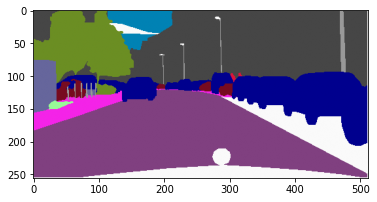

500it [02:08,  3.90it/s]


In [13]:
train_models(0)
training_loss(0)
eval_metrics(0)
visualize_results(0)

Epoch 1
-------------------------------


C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Image: 50 in epoch: [1/3] and Avg Loss of last 50: 4.3615
Image: 100 in epoch: [1/3] and Avg Loss of last 50: 2.0596
Image: 150 in epoch: [1/3] and Avg Loss of last 50: 1.8450
Image: 200 in epoch: [1/3] and Avg Loss of last 50: 1.3507
Image: 250 in epoch: [1/3] and Avg Loss of last 50: 1.6530
Image: 300 in epoch: [1/3] and Avg Loss of last 50: 1.3652
Image: 350 in epoch: [1/3] and Avg Loss of last 50: 1.3735
Image: 400 in epoch: [1/3] and Avg Loss of last 50: 1.2446
Image: 450 in epoch: [1/3] and Avg Loss of last 50: 1.4959
Image: 500 in epoch: [1/3] and Avg Loss of last 50: 1.2339
Image: 550 in epoch: [1/3] and Avg Loss of last 50: 1.2866
Image: 600 in epoch: [1/3] and Avg Loss of last 50: 1.1944
Image: 650 in epoch: [1/3] and Avg Loss of last 50: 1.2650
Image: 700 in epoch: [1/3] and Avg Loss of last 50: 1.2117
Image: 750 in epoch: [1/3] and Avg Loss of last 50: 1.1332
Image: 800 in epoch: [1/3] and Avg Loss of last 50: 1.0758
Image: 850 in epoch: [1/3] and Avg Loss of last 50: 1.112

500it [02:28,  3.36it/s]
C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Different Metrics were:  {'Specificity': 0.9753864669294474, 'Senstivity': 0.24768813461796513, 'F1': 0.22773238111581123, 'acc': 0.5189035491943359, 'js': 0.3627499358960412}
Epoch 2
-------------------------------
Image: 50 in epoch: [2/3] and Avg Loss of last 50: 0.9096
Image: 100 in epoch: [2/3] and Avg Loss of last 50: 0.7941
Image: 150 in epoch: [2/3] and Avg Loss of last 50: 0.8455
Image: 200 in epoch: [2/3] and Avg Loss of last 50: 0.8679
Image: 250 in epoch: [2/3] and Avg Loss of last 50: 0.8428
Image: 300 in epoch: [2/3] and Avg Loss of last 50: 0.7096
Image: 350 in epoch: [2/3] and Avg Loss of last 50: 0.6819
Image: 400 in epoch: [2/3] and Avg Loss of last 50: 0.7471
Image: 450 in epoch: [2/3] and Avg Loss of last 50: 0.7511
Image: 500 in epoch: [2/3] and Avg Loss of last 50: 0.7357
Image: 550 in epoch: [2/3] and Avg Loss of last 50: 0.8797
Image: 600 in epoch: [2/3] and Avg Loss of last 50: 0.8360
Image: 650 in epoch: [2/3] and Avg Loss of last 50: 0.8322
Image: 700 in epoc

500it [02:22,  3.50it/s]
C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Different Metrics were:  {'Specificity': 0.9687488526050945, 'Senstivity': 0.25332047545812886, 'F1': 0.24630867591941838, 'acc': 0.4254317321777344, 'js': 0.2788419306246841}
Epoch 3
-------------------------------
Image: 50 in epoch: [3/3] and Avg Loss of last 50: 0.6130
Image: 100 in epoch: [3/3] and Avg Loss of last 50: 0.6211
Image: 150 in epoch: [3/3] and Avg Loss of last 50: 0.5830
Image: 200 in epoch: [3/3] and Avg Loss of last 50: 0.7039
Image: 250 in epoch: [3/3] and Avg Loss of last 50: 0.6185
Image: 300 in epoch: [3/3] and Avg Loss of last 50: 0.5751
Image: 350 in epoch: [3/3] and Avg Loss of last 50: 0.5729
Image: 400 in epoch: [3/3] and Avg Loss of last 50: 0.6206
Image: 450 in epoch: [3/3] and Avg Loss of last 50: 0.6746
Image: 500 in epoch: [3/3] and Avg Loss of last 50: 0.5484
Image: 550 in epoch: [3/3] and Avg Loss of last 50: 0.5864
Image: 600 in epoch: [3/3] and Avg Loss of last 50: 0.5939
Image: 650 in epoch: [3/3] and Avg Loss of last 50: 0.6714
Image: 700 in epoc

500it [02:23,  3.48it/s]


Different Metrics were:  {'Specificity': 0.9661980705462311, 'Senstivity': 0.24707326838381533, 'F1': 0.23067460094542522, 'acc': 0.39328321838378905, 'js': 0.25298992247168106}


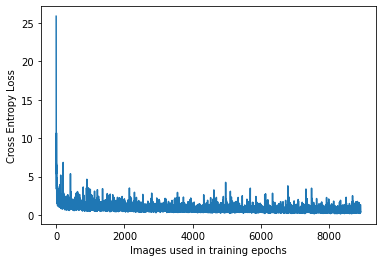

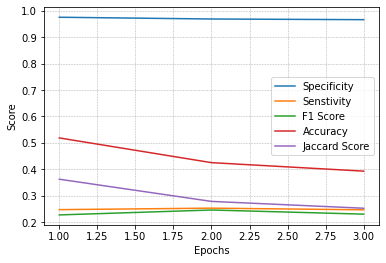

0it [00:00, ?it/s]

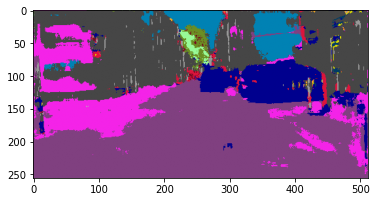

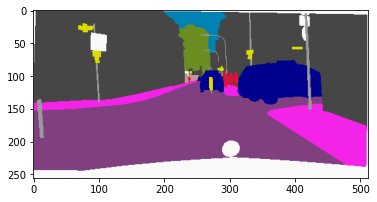

100it [00:25,  3.89it/s]

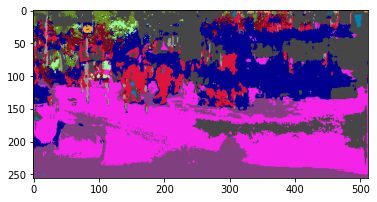

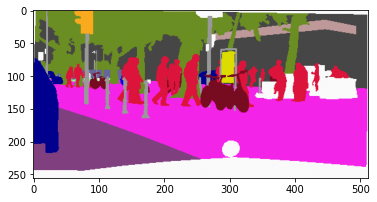

200it [00:51,  3.96it/s]

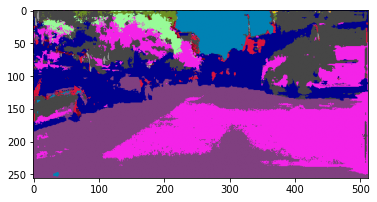

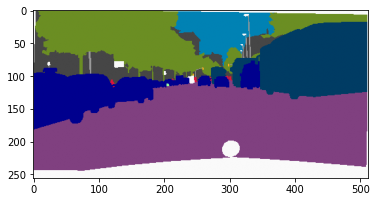

300it [01:17,  3.94it/s]

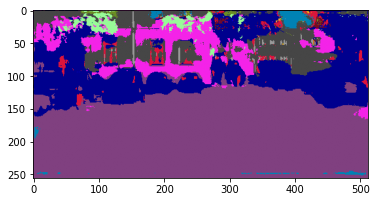

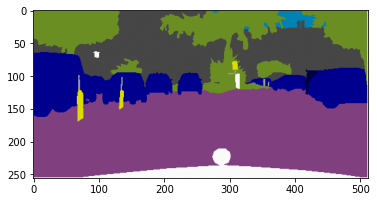

400it [01:42,  3.99it/s]

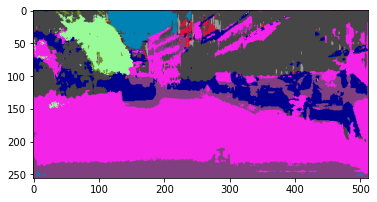

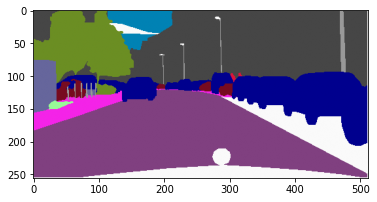

500it [02:08,  3.89it/s]


In [14]:
train_models(1)
training_loss(1)
eval_metrics(1)
visualize_results(1)

Epoch 1
-------------------------------


C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Image: 50 in epoch: [1/3] and Avg Loss of last 50: 4.4377
Image: 100 in epoch: [1/3] and Avg Loss of last 50: 1.8465
Image: 150 in epoch: [1/3] and Avg Loss of last 50: 1.4936
Image: 200 in epoch: [1/3] and Avg Loss of last 50: 1.5938
Image: 250 in epoch: [1/3] and Avg Loss of last 50: 1.6704
Image: 300 in epoch: [1/3] and Avg Loss of last 50: 1.3391
Image: 350 in epoch: [1/3] and Avg Loss of last 50: 1.5365
Image: 400 in epoch: [1/3] and Avg Loss of last 50: 1.9730
Image: 450 in epoch: [1/3] and Avg Loss of last 50: 1.3672
Image: 500 in epoch: [1/3] and Avg Loss of last 50: 1.3793
Image: 550 in epoch: [1/3] and Avg Loss of last 50: 1.0998
Image: 600 in epoch: [1/3] and Avg Loss of last 50: 1.2094
Image: 650 in epoch: [1/3] and Avg Loss of last 50: 1.1816
Image: 700 in epoch: [1/3] and Avg Loss of last 50: 1.2021
Image: 750 in epoch: [1/3] and Avg Loss of last 50: 1.0922
Image: 800 in epoch: [1/3] and Avg Loss of last 50: 1.0922
Image: 850 in epoch: [1/3] and Avg Loss of last 50: 1.063

500it [02:26,  3.41it/s]
C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Different Metrics were:  {'Specificity': 0.971412529411576, 'Senstivity': 0.2581876277093645, 'F1': 0.21410060781300966, 'acc': 0.4476478118896484, 'js': 0.2995063305375103}
Epoch 2
-------------------------------
Image: 50 in epoch: [2/3] and Avg Loss of last 50: 0.7358
Image: 100 in epoch: [2/3] and Avg Loss of last 50: 0.7272
Image: 150 in epoch: [2/3] and Avg Loss of last 50: 0.6949
Image: 200 in epoch: [2/3] and Avg Loss of last 50: 0.6979
Image: 250 in epoch: [2/3] and Avg Loss of last 50: 0.7576
Image: 300 in epoch: [2/3] and Avg Loss of last 50: 0.6335
Image: 350 in epoch: [2/3] and Avg Loss of last 50: 0.6793
Image: 400 in epoch: [2/3] and Avg Loss of last 50: 0.7666
Image: 450 in epoch: [2/3] and Avg Loss of last 50: 0.7732
Image: 500 in epoch: [2/3] and Avg Loss of last 50: 0.7944
Image: 550 in epoch: [2/3] and Avg Loss of last 50: 0.7779
Image: 600 in epoch: [2/3] and Avg Loss of last 50: 0.7015
Image: 650 in epoch: [2/3] and Avg Loss of last 50: 0.7783
Image: 700 in epoch:

500it [02:26,  3.41it/s]
C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Different Metrics were:  {'Specificity': 0.9686993797206632, 'Senstivity': 0.33544827659571036, 'F1': 0.2565911697394311, 'acc': 0.43017274475097655, 'js': 0.28446464653959813}
Epoch 3
-------------------------------
Image: 50 in epoch: [3/3] and Avg Loss of last 50: 0.5841
Image: 100 in epoch: [3/3] and Avg Loss of last 50: 0.5994
Image: 150 in epoch: [3/3] and Avg Loss of last 50: 0.6160
Image: 200 in epoch: [3/3] and Avg Loss of last 50: 0.6424
Image: 250 in epoch: [3/3] and Avg Loss of last 50: 0.5999
Image: 300 in epoch: [3/3] and Avg Loss of last 50: 0.5733
Image: 350 in epoch: [3/3] and Avg Loss of last 50: 0.5502
Image: 400 in epoch: [3/3] and Avg Loss of last 50: 0.5913
Image: 450 in epoch: [3/3] and Avg Loss of last 50: 0.5928
Image: 500 in epoch: [3/3] and Avg Loss of last 50: 0.5291
Image: 550 in epoch: [3/3] and Avg Loss of last 50: 0.5296
Image: 600 in epoch: [3/3] and Avg Loss of last 50: 0.5707
Image: 650 in epoch: [3/3] and Avg Loss of last 50: 0.5973
Image: 700 in epo

500it [02:30,  3.31it/s]


Different Metrics were:  {'Specificity': 0.9777344535951381, 'Senstivity': 0.2581845006704879, 'F1': 0.24867054477984557, 'acc': 0.5421142883300781, 'js': 0.3812865965995789}


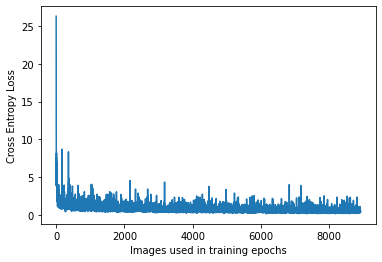

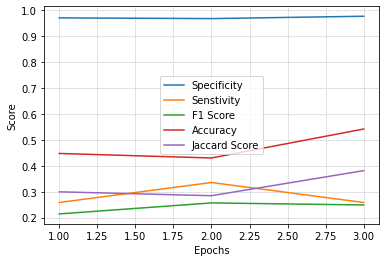

0it [00:00, ?it/s]

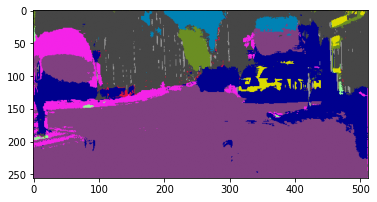

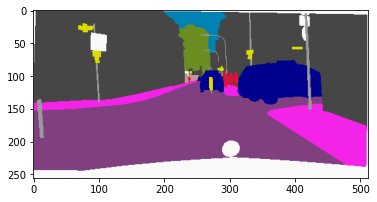

100it [00:27,  3.71it/s]

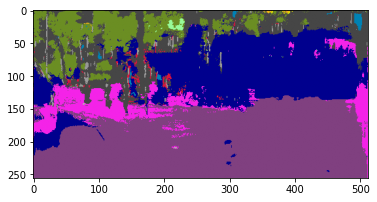

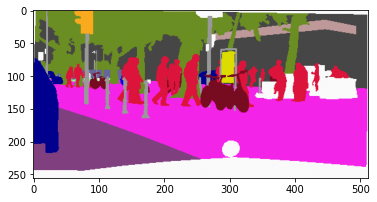

200it [00:54,  3.79it/s]

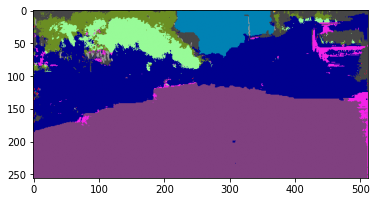

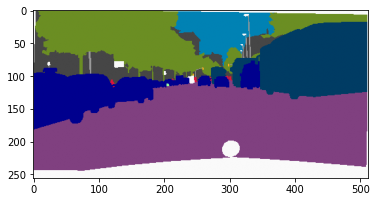

300it [01:22,  3.41it/s]

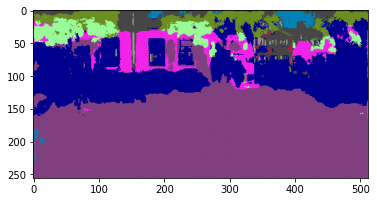

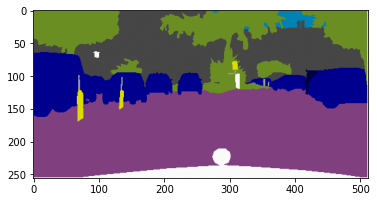

400it [01:51,  3.44it/s]

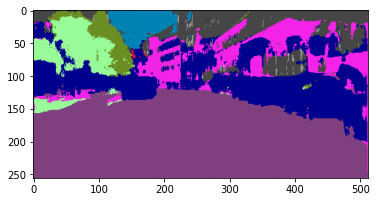

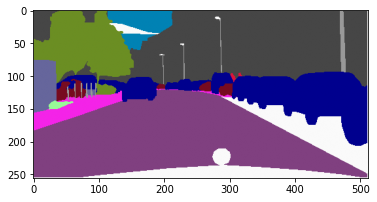

500it [02:20,  3.57it/s]


In [15]:
train_models(2)
training_loss(2)
eval_metrics(2)
visualize_results(2)

Epoch 1
-------------------------------


C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Image: 50 in epoch: [1/3] and Avg Loss of last 50: 3.1059
Image: 100 in epoch: [1/3] and Avg Loss of last 50: 2.5631
Image: 150 in epoch: [1/3] and Avg Loss of last 50: 1.7860
Image: 200 in epoch: [1/3] and Avg Loss of last 50: 1.7767
Image: 250 in epoch: [1/3] and Avg Loss of last 50: 1.4848
Image: 300 in epoch: [1/3] and Avg Loss of last 50: 1.2556
Image: 350 in epoch: [1/3] and Avg Loss of last 50: 1.2177
Image: 400 in epoch: [1/3] and Avg Loss of last 50: 1.0275
Image: 450 in epoch: [1/3] and Avg Loss of last 50: 1.2975
Image: 500 in epoch: [1/3] and Avg Loss of last 50: 1.3863
Image: 550 in epoch: [1/3] and Avg Loss of last 50: 1.1827
Image: 600 in epoch: [1/3] and Avg Loss of last 50: 1.0172
Image: 650 in epoch: [1/3] and Avg Loss of last 50: 1.0071
Image: 700 in epoch: [1/3] and Avg Loss of last 50: 1.1218
Image: 750 in epoch: [1/3] and Avg Loss of last 50: 0.9065
Image: 800 in epoch: [1/3] and Avg Loss of last 50: 1.0050
Image: 850 in epoch: [1/3] and Avg Loss of last 50: 0.889

500it [02:40,  3.11it/s]
C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Different Metrics were:  {'Specificity': 0.9805277040295115, 'Senstivity': 0.2845047645454249, 'F1': 0.2646351706643778, 'acc': 0.6097129364013671, 'js': 0.4535431109581125}
Epoch 2
-------------------------------
Image: 50 in epoch: [2/3] and Avg Loss of last 50: 0.7329
Image: 100 in epoch: [2/3] and Avg Loss of last 50: 1.2665
Image: 150 in epoch: [2/3] and Avg Loss of last 50: 0.8927
Image: 200 in epoch: [2/3] and Avg Loss of last 50: 0.8543
Image: 250 in epoch: [2/3] and Avg Loss of last 50: 0.7617
Image: 300 in epoch: [2/3] and Avg Loss of last 50: 0.6960
Image: 350 in epoch: [2/3] and Avg Loss of last 50: 0.7713
Image: 400 in epoch: [2/3] and Avg Loss of last 50: 0.7341
Image: 450 in epoch: [2/3] and Avg Loss of last 50: 0.6623
Image: 500 in epoch: [2/3] and Avg Loss of last 50: 0.8060
Image: 550 in epoch: [2/3] and Avg Loss of last 50: 0.7392
Image: 600 in epoch: [2/3] and Avg Loss of last 50: 0.6806
Image: 650 in epoch: [2/3] and Avg Loss of last 50: 0.6505
Image: 700 in epoch:

500it [02:45,  3.03it/s]
C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Different Metrics were:  {'Specificity': 0.9825159504545372, 'Senstivity': 0.37689972122837395, 'F1': 0.28315713088464933, 'acc': 0.6229237365722656, 'js': 0.46327448663276516}
Epoch 3
-------------------------------
Image: 50 in epoch: [3/3] and Avg Loss of last 50: 0.5850
Image: 100 in epoch: [3/3] and Avg Loss of last 50: 0.5138
Image: 150 in epoch: [3/3] and Avg Loss of last 50: 0.6599
Image: 200 in epoch: [3/3] and Avg Loss of last 50: 0.6119
Image: 250 in epoch: [3/3] and Avg Loss of last 50: 0.5690
Image: 300 in epoch: [3/3] and Avg Loss of last 50: 0.5796
Image: 350 in epoch: [3/3] and Avg Loss of last 50: 0.5376
Image: 400 in epoch: [3/3] and Avg Loss of last 50: 0.5193
Image: 450 in epoch: [3/3] and Avg Loss of last 50: 0.5429
Image: 500 in epoch: [3/3] and Avg Loss of last 50: 0.5681
Image: 550 in epoch: [3/3] and Avg Loss of last 50: 0.5342
Image: 600 in epoch: [3/3] and Avg Loss of last 50: 0.5609
Image: 650 in epoch: [3/3] and Avg Loss of last 50: 0.6008
Image: 700 in epo

500it [02:37,  3.18it/s]


Different Metrics were:  {'Specificity': 0.9771359848962603, 'Senstivity': 0.3591200433116373, 'F1': 0.2897660221368347, 'acc': 0.5560193786621094, 'js': 0.39671140774409924}


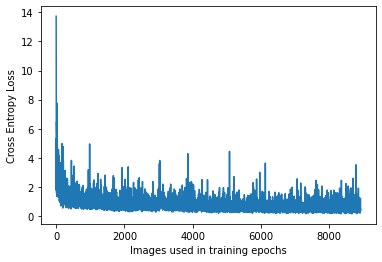

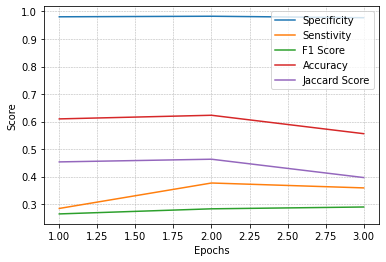

0it [00:00, ?it/s]

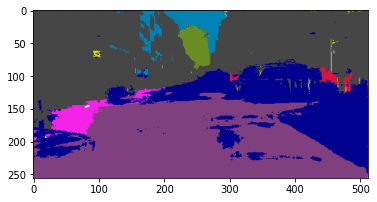

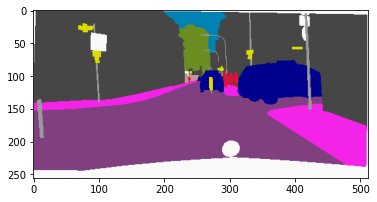

100it [00:28,  3.55it/s]

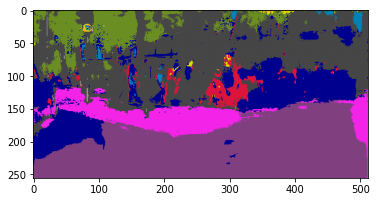

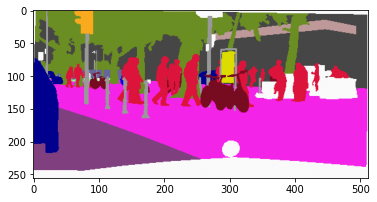

200it [00:57,  3.55it/s]

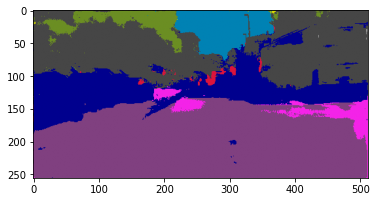

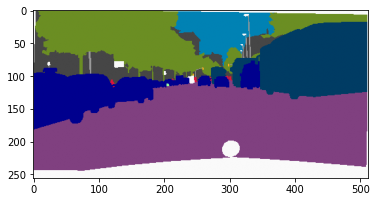

300it [01:25,  3.59it/s]

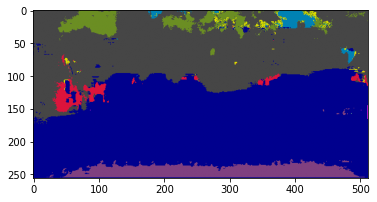

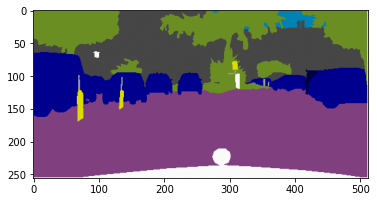

400it [01:53,  3.56it/s]

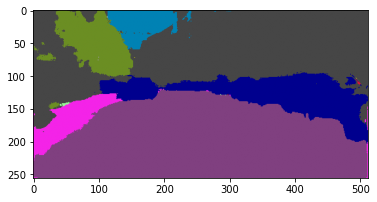

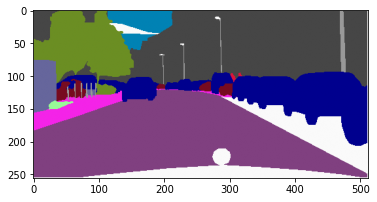

500it [02:22,  3.51it/s]


In [16]:
train_models(3)
training_loss(3)
eval_metrics(3)
visualize_results(3)

Epoch 1
-------------------------------


C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Image: 50 in epoch: [1/3] and Avg Loss of last 50: 2.7279
Image: 100 in epoch: [1/3] and Avg Loss of last 50: 1.6360
Image: 150 in epoch: [1/3] and Avg Loss of last 50: 1.3539
Image: 200 in epoch: [1/3] and Avg Loss of last 50: 1.3957
Image: 250 in epoch: [1/3] and Avg Loss of last 50: 1.4440
Image: 300 in epoch: [1/3] and Avg Loss of last 50: 1.1999
Image: 350 in epoch: [1/3] and Avg Loss of last 50: 1.5261
Image: 400 in epoch: [1/3] and Avg Loss of last 50: 1.0673
Image: 450 in epoch: [1/3] and Avg Loss of last 50: 1.0880
Image: 500 in epoch: [1/3] and Avg Loss of last 50: 1.2138
Image: 550 in epoch: [1/3] and Avg Loss of last 50: 1.2530
Image: 600 in epoch: [1/3] and Avg Loss of last 50: 1.2631
Image: 650 in epoch: [1/3] and Avg Loss of last 50: 1.2918
Image: 700 in epoch: [1/3] and Avg Loss of last 50: 1.1525
Image: 750 in epoch: [1/3] and Avg Loss of last 50: 1.0355
Image: 800 in epoch: [1/3] and Avg Loss of last 50: 1.0827
Image: 850 in epoch: [1/3] and Avg Loss of last 50: 0.996

500it [02:48,  2.97it/s]
C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Different Metrics were:  {'Specificity': 0.9820266532904355, 'Senstivity': 0.2949184002814243, 'F1': 0.2652319367413691, 'acc': 0.6153682403564453, 'js': 0.45571127011492063}
Epoch 2
-------------------------------
Image: 50 in epoch: [2/3] and Avg Loss of last 50: 0.7487
Image: 100 in epoch: [2/3] and Avg Loss of last 50: 0.6236
Image: 150 in epoch: [2/3] and Avg Loss of last 50: 0.6573
Image: 200 in epoch: [2/3] and Avg Loss of last 50: 0.8319
Image: 250 in epoch: [2/3] and Avg Loss of last 50: 0.7074
Image: 300 in epoch: [2/3] and Avg Loss of last 50: 0.6520
Image: 350 in epoch: [2/3] and Avg Loss of last 50: 0.7159
Image: 400 in epoch: [2/3] and Avg Loss of last 50: 0.6326
Image: 450 in epoch: [2/3] and Avg Loss of last 50: 0.7098
Image: 500 in epoch: [2/3] and Avg Loss of last 50: 0.7092
Image: 550 in epoch: [2/3] and Avg Loss of last 50: 0.6814
Image: 600 in epoch: [2/3] and Avg Loss of last 50: 0.7657
Image: 650 in epoch: [2/3] and Avg Loss of last 50: 0.6239
Image: 700 in epoch

500it [02:53,  2.88it/s]
C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Different Metrics were:  {'Specificity': 0.9827802172420007, 'Senstivity': 0.2879065320151776, 'F1': 0.2641755886638353, 'acc': 0.6187221527099609, 'js': 0.4589282938571762}
Epoch 3
-------------------------------
Image: 50 in epoch: [3/3] and Avg Loss of last 50: 0.6148
Image: 100 in epoch: [3/3] and Avg Loss of last 50: 0.5949
Image: 150 in epoch: [3/3] and Avg Loss of last 50: 0.6681
Image: 200 in epoch: [3/3] and Avg Loss of last 50: 0.6292
Image: 250 in epoch: [3/3] and Avg Loss of last 50: 0.5979
Image: 300 in epoch: [3/3] and Avg Loss of last 50: 0.5212
Image: 350 in epoch: [3/3] and Avg Loss of last 50: 0.6652
Image: 400 in epoch: [3/3] and Avg Loss of last 50: 0.5862
Image: 450 in epoch: [3/3] and Avg Loss of last 50: 0.5896
Image: 500 in epoch: [3/3] and Avg Loss of last 50: 0.5196
Image: 550 in epoch: [3/3] and Avg Loss of last 50: 0.5720
Image: 600 in epoch: [3/3] and Avg Loss of last 50: 0.5759
Image: 650 in epoch: [3/3] and Avg Loss of last 50: 0.5734
Image: 700 in epoch:

500it [03:27,  2.41it/s]


Different Metrics were:  {'Specificity': 0.9833947627607084, 'Senstivity': 0.32798869959281945, 'F1': 0.2897630851398226, 'acc': 0.6362225952148437, 'js': 0.47908985048250535}


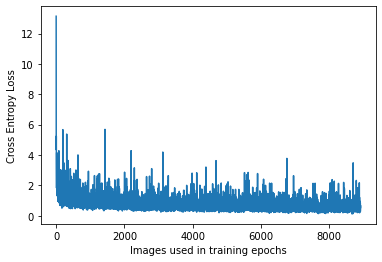

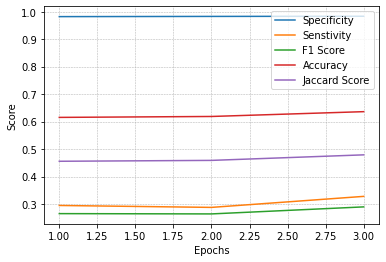

0it [00:00, ?it/s]

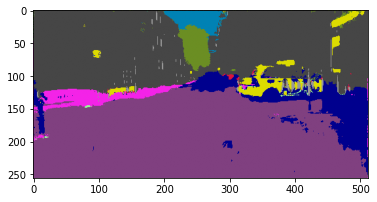

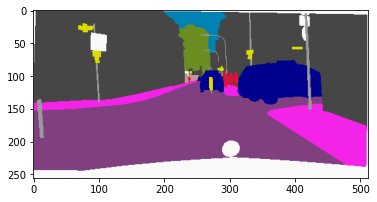

100it [00:38,  2.47it/s]

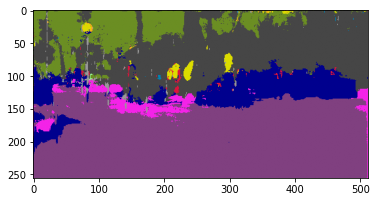

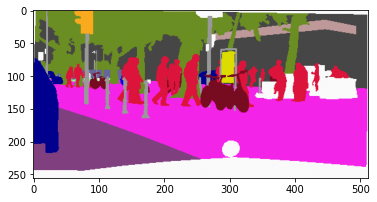

200it [01:16,  2.79it/s]

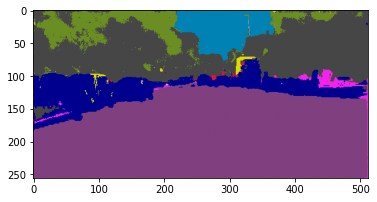

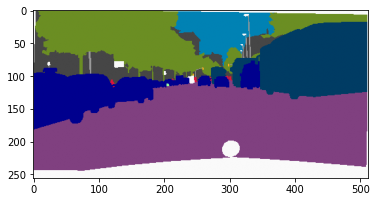

300it [01:53,  2.78it/s]

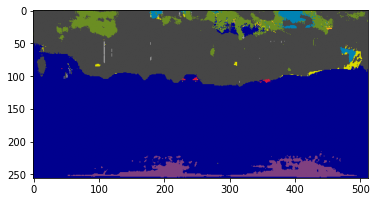

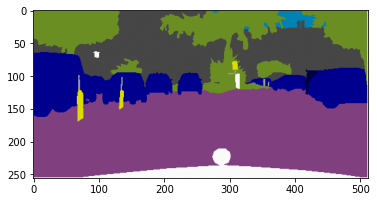

400it [02:30,  2.66it/s]

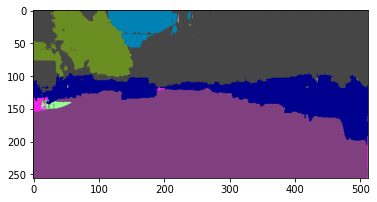

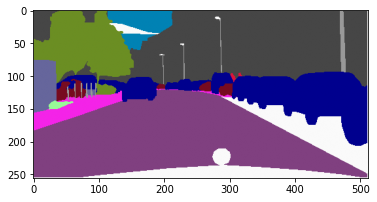

500it [03:06,  2.69it/s]


In [17]:
train_models(4)
training_loss(4)
eval_metrics(4)
visualize_results(4)